## Proyecto Final

El presente proyecto toma como punto de partido el proyecto 01 y 02 relacionados al DataSet inmobiliario de properati para la ciudad de Buenos Aires. 

En un primer momento, se buscara realizar un analisis exploratorio de datos mas detallados con el ojbetivo de conseguir y presentar informacion que sea relevante comunicar pensando desde el punto de vista de un inversor o persona interesada en alquilar un inmueble.

En un segundo momento, se retomaran los modelos de machine learning ya desarrollados, y se continuara con el analisis a partir de los mismos. Adicionalmente, se buscara trabajar con las variables mas relevantes de acuerdo a las observaciones realizadas y se aplicaran nuevos modelos para determinar posibles mejores en la prediccion de valores.

In [1]:
#Importamos las librerias a implementar
%config IPCompleter.greedy = True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
#Cargamos el DataSet correspondiente para trabajar
properati = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

In [3]:
#Determinamos la demonicacion de las columnas que posee el DataFrame
properati.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

In [4]:
#Se filtra el dataframe a los fines de tomar solo aquellas variables que son importantes. Se dejan de lado las fechas de creacion y cierre, 
#la moneda a la cual se esta valuando, la descripcion de la propiedad y el tipo de operacion
properati = properati[['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]

In [5]:
# Imprimimos el shape del DF para tener conocimiento del tamaño y distribucion de los datos a utilizar.
properati.shape

(146660, 8)

## Parte A: Analisis exploratorio

#### Pregunta guia: cuales barrios serian mejor opcion para alquilar? Que deberia tomarse en consideracion para la toma de decision? Como podria ampliarse dicho analisis a una inversion en la compra de un inmueble y su posterior alquiler como inversion?

### Tratamiento de Outliers

<AxesSubplot:xlabel='price'>

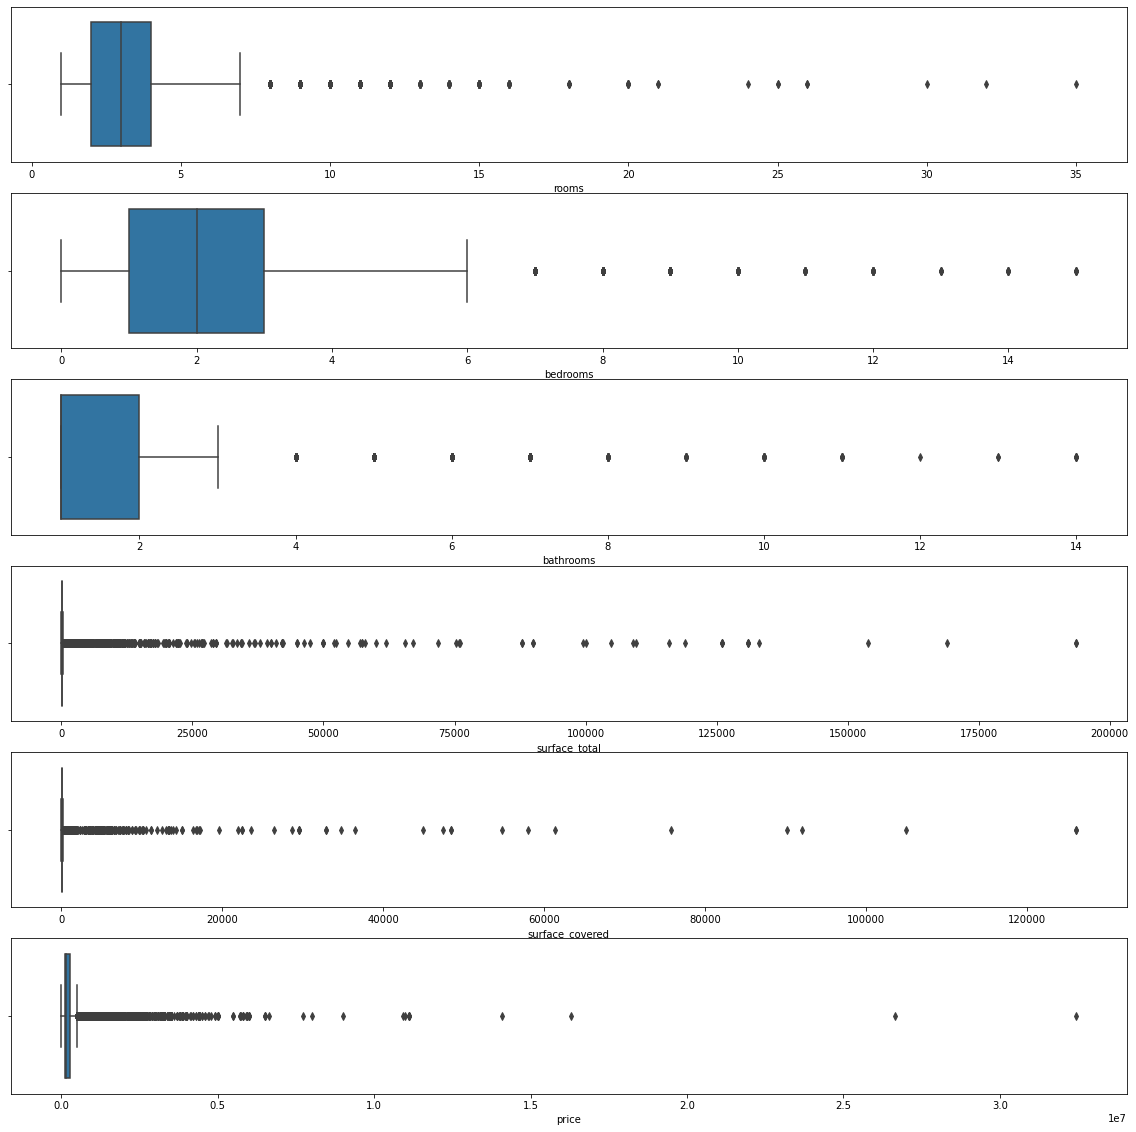

In [6]:
# En primer medida, se realiza un grafico de caja para determinar presencia de Outliers.
fig, axes = plt.subplots(6,1, figsize=(20, 20))
sns.boxplot(data = properati, x = "rooms", ax=axes[0])
sns.boxplot(data = properati, x = "bedrooms", ax=axes[1])
sns.boxplot(data = properati, x = 'bathrooms', ax=axes[2])
sns.boxplot(data = properati, x = 'surface_total', ax=axes[3])
sns.boxplot(data = properati, x = 'surface_covered', ax=axes[4])
sns.boxplot(data = properati, x = 'price', ax=axes[5])

Del grafico anterior, se observa la presencia de Outliers, principalmente en las columnas relacionadas a la superficie y precio.

Para la limpieza de los valores atipicos, se realizara tratamiento por medio de IQR

In [7]:
#Procedemos a determinar minimo, maximo e IQR para las variables observadas e imprimimos los valores correspondientes
Q1 = properati.quantile(0.25)
Q3 = properati.quantile(0.75)
iqr = Q3 - Q1
minimo = Q1 - 1.5*iqr
maximo = Q3 + 1.5*iqr
print("Valor minimo: ", minimo)
print("Valor maximo: ", maximo)
print("IQR: ", iqr)

Valor minimo:  rooms                  -1.0
bedrooms               -2.0
bathrooms              -0.5
surface_total         -80.0
surface_covered       -44.5
price             -120000.0
dtype: float64
Valor maximo:  rooms                   7.0
bedrooms                6.0
bathrooms               3.5
surface_total         272.0
surface_covered       199.5
price              496000.0
dtype: float64
IQR:  rooms                   2.0
bedrooms                2.0
bathrooms               1.0
surface_total          88.0
surface_covered        61.0
price              154000.0
dtype: float64


In [8]:
# Realizamos el filtrado correspondiente de acuerdo a los valores obtenidos en el punto anterior.
properati = properati[~((properati < minimo) |(properati > maximo)).any(axis=1)] # Se actualiza el DF inicial para continuar el desarrollo.
properati.shape # Imprimimos las dimensiones en pantalla

(122754, 8)

### Imputacion de valores faltantes

In [9]:
# Se determina la presencia de valores faltantes.
properati.isna().sum()

l3                     0
rooms                  0
bedrooms               0
bathrooms           4896
surface_total      18678
surface_covered    19072
price                  0
property_type          0
dtype: int64

In [10]:
# Se observan valores faltantes en 3 variables. A los fines de completarlas y, 
# atento a que se esta trabajando con un DF "sin" outliers, se procedera a completar con la media de las observaciones,
# situacion que es factible atento a que se esta trabajando con valores cuantitativos
properati = properati.fillna(properati.mean())

In [11]:
# Aplicamos la funcion describe a los fines de tomar conocimiento respecto a la distribucion de las variables.
properati.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,122754.000000,122754.000000,122754.000000,122754.000000,122754.000000,122754.000000
mean,2.763323,1.746477,1.383444,81.216371,68.041589,175478.747104
std,1.070475,0.940687,0.579897,41.985232,29.766663,93264.989239
min,1.000000,0.000000,1.000000,10.000000,1.000000,6000.000000
25%,2.000000,1.000000,1.000000,52.000000,46.000000,105000.000000
50%,3.000000,2.000000,1.000000,77.000000,67.000000,150300.500000
75%,3.000000,2.000000,2.000000,91.000000,78.000000,225000.000000
max,7.000000,6.000000,3.000000,272.000000,199.000000,496000.000000


#### Analisis Exploratorio

In [12]:
# Se establece el precio medio por tipo de propiedad
precio_propiedad = properati.groupby(['property_type'])['price'].mean()
precio_propiedad = pd.DataFrame(precio_propiedad.items(), columns = ['Tipo Propiedad', 'Precio Medio'])
precio_propiedad = precio_propiedad.sort_values(['Precio Medio']).reset_index(drop=True)

<AxesSubplot:title={'center':'Precio medio por tipo de propiedad'}, xlabel='Tipo Propiedad', ylabel='Precio Medio'>

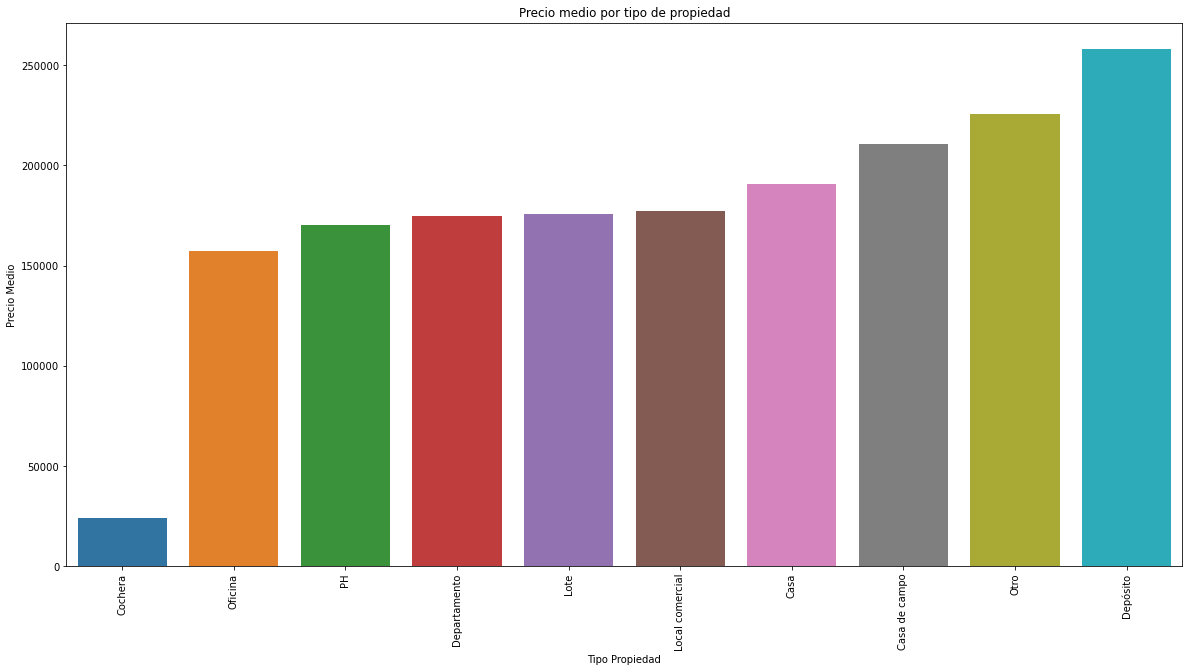

In [13]:
# Se grafica la distribucion anterior a los fines de observar los registros de menor a mayor
plt.figure(figsize=(20, 10))
plt.title("Precio medio por tipo de propiedad")
plt.xticks(rotation=90)
sns.barplot(data = precio_propiedad, x = "Tipo Propiedad", y = 'Precio Medio')

Del grafico anterior, se evidencia una diferencia importante en el valor medio del tipo de propiedad "cochera" con el resto de propiedades, motivo por el cual, se procedera a filtrar el dataframe dejando de lado dicho registro y evitar sesgos en la informacion que pueda obtenerse, principalmente al trabajar con valores de los barrios.

In [14]:
# Se realiza el filtrado correspondiente
properati = properati.loc[(properati['property_type'] != 'Cochera')]

In [15]:
# Se establece el precio medio por tipo de propiedad
precio_propiedad = properati.groupby(['property_type'])['price'].mean()
precio_propiedad = pd.DataFrame(precio_propiedad.items(), columns = ['Tipo Propiedad', 'Precio Medio'])
precio_propiedad = precio_propiedad.sort_values(['Precio Medio']).reset_index(drop=True)

<AxesSubplot:title={'center':'Precio medio por tipo de propiedad'}, xlabel='Tipo Propiedad', ylabel='Precio Medio'>

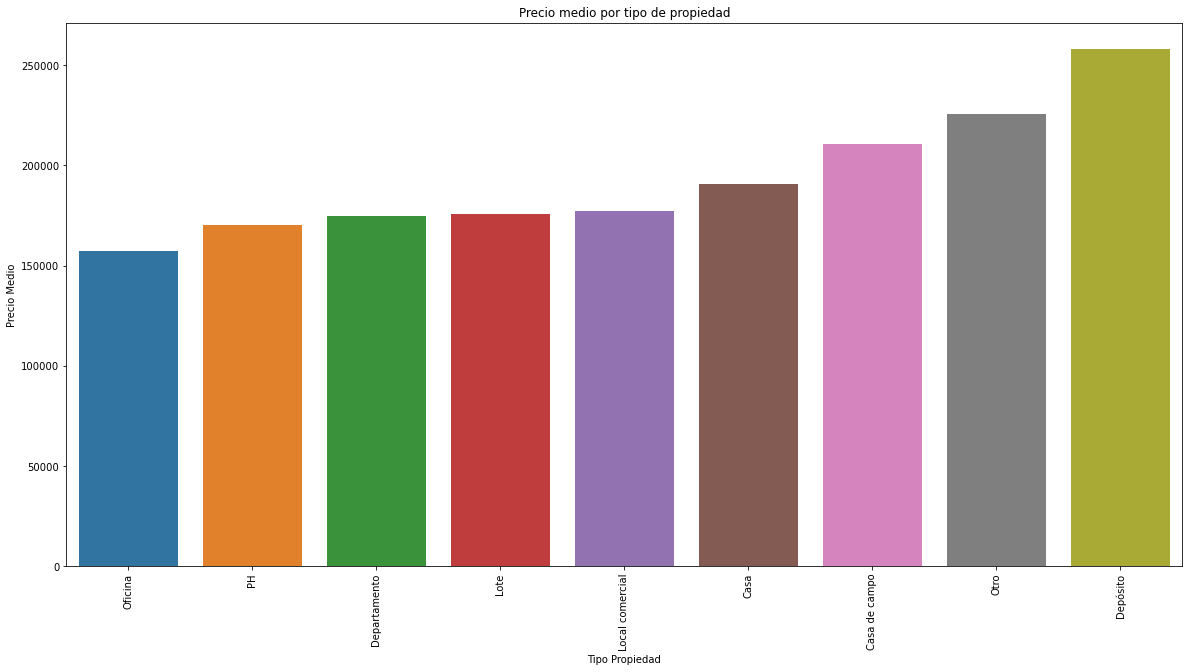

In [16]:
# Se grafica la distribucion anterior a los fines de observar los registros de menor a mayor
plt.figure(figsize=(20, 10))
plt.title("Precio medio por tipo de propiedad")
plt.xticks(rotation=90)
sns.barplot(data = precio_propiedad, x = "Tipo Propiedad", y = 'Precio Medio')

Se observa un mayor valor por los "Depositos". Respecto a los inmuebles destinados a vivienda, no se evidencia una variacion significativa en los precios medios obtenidos, adicionalmente si consideramos que los 3 registros principales se corresponden a "PH", "Departamento" y "Casa", dicha variacion se vuelve todavia menor.

In [17]:
# Determinamos el costo promedio por barrio, lo ordenamos de menor a mayor e imprimimos el head y el tail.
barrio_precio = properati.groupby(['l3'])['price'].mean()
barrio_precio = pd.DataFrame(barrio_precio.items(), columns = ['Barrio', 'Precio Medio'])
barrio_precio = barrio_precio.sort_values(['Precio Medio']).reset_index(drop=True)
print(barrio_precio.head())
print(barrio_precio.tail())

            Barrio   Precio Medio
0       José C Paz   71583.989189
1    Villa Soldati   78093.877551
2     Constitución   96069.741866
3     Villa Lugano  104533.401345
4  Tres de Febrero  105337.613095
           Barrio   Precio Medio
84     San Isidro  236535.932909
85       Belgrano  237426.270390
86       Recoleta  249145.123321
87    Las Cañitas  268136.743925
88  Puerto Madero  352646.204082


<AxesSubplot:title={'center':'Precio medio por barrio'}, xlabel='Barrio', ylabel='Precio Medio'>

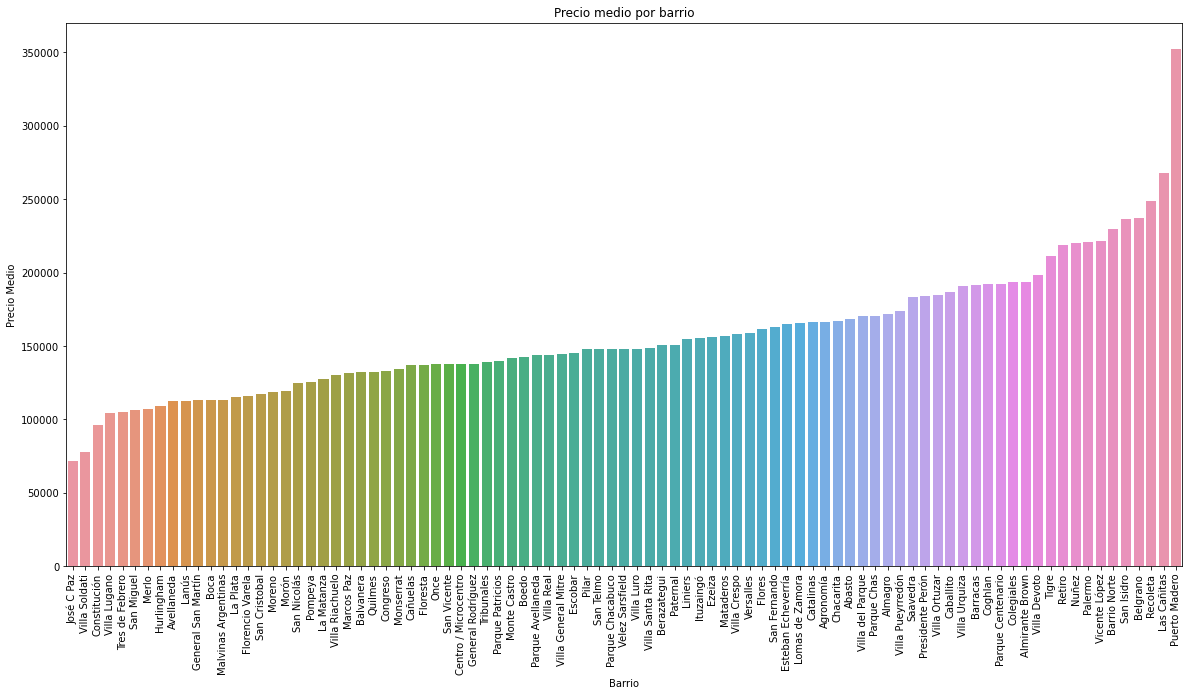

In [18]:
# Realizamos un grafico de barras ordenado de menor a mayor para visualizar con claridad la distribucion del datafrane del precio medio de los distintos barrios
plt.figure(figsize=(20, 10))
plt.title("Precio medio por barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_precio, x = "Barrio", y = 'Precio Medio')

In [19]:
# Procedemos a complementar el analisis con la funcion describe
barrio_precio.describe()

,Precio Medio
count,89.000000
mean,156952.655595
std,43749.895854
min,71583.989189
25%,131736.842105
50%,148239.082418
75%,173591.995562
max,352646.204082


<AxesSubplot:xlabel='Precio Medio'>

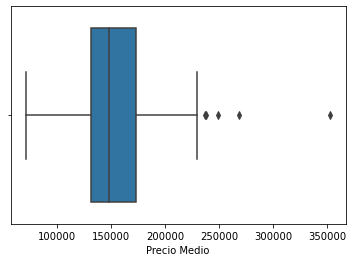

In [20]:
# Por medio de un boxplot, graficamos la distribucion observada con la funcion describe()
sns.boxplot(data = barrio_precio, x = "Precio Medio")

Del grafico de barras, de la funcion describe y del boxplot, se puede observar con claridad:
* La mayoria de los barrios se ubican en torno a un valor medio de 150.000,00, siendo la mediana de 148.239,08.
* Con una desviacion estandar de 43.749,89, y considerando que el Q1 y el Q3 son de 131.736,84 y 173.591,99 respectivamente, podemos afirmar que la mayoria de los barrios oscilan su precio entre cien mil y doscientos mil dolares.
* El valor correspondiente a Puerto Madero, se puede establecer como un Outlier, siendo la diferencia con Las Cañitas (segundo barrio mas caro) de 84.509,46, valor aproximado a dos desviaciones estandar.
* El valor de Puerto Madero supera en 4,47 veces la desviacion estandar a la media del dataframe.
* El valor del punto anterior se ve reducido a un poco mas de la mitad, 1,95 veces, si consideramos al barrio de menor precio medio, Jose C. Paz

Es importante considerar que los valores se establecieron sin discriminar tipo de propiedad

In [21]:
# Determinamos el costo maximo por barrio, lo ordenamos de menor a mayor e imprimimos el head() y el tail().
barrio_max = properati.groupby(['l3'])['price'].max()
barrio_max = pd.DataFrame(barrio_max.items(), columns = ['Barrio', 'Precio Maximo'])
barrio_max = barrio_max.sort_values(['Precio Maximo']).reset_index(drop=True)
print(barrio_max.head())
print(barrio_max.tail())

             Barrio  Precio Maximo
0     Villa Soldati       150000.0
1   Villa Riachuelo       280000.0
2  Florencio Varela       280000.0
3         Catalinas       280000.0
4        Villa Real       315000.0
       Barrio  Precio Maximo
84     Ezeiza       495800.0
85  Chacarita       496000.0
86    Palermo       496000.0
87   Belgrano       496000.0
88      Nuñez       496000.0


In [22]:
# Determinamos el costo minimo por barrio, lo ordenamos de menor a mayor e imprimimos el head().
barrio_min = properati.groupby(['l3'])['price'].min()
barrio_min = pd.DataFrame(barrio_min.items(), columns = ['Barrio', 'Precio Minimo'])
barrio_min = barrio_min.sort_values(['Precio Minimo']).reset_index(drop=True)
print(barrio_min.head())
print(barrio_min.tail())

             Barrio  Precio Minimo
0     Puerto Madero         6000.0
1            Moreno         7500.0
2  Parque Chacabuco         7500.0
3           Palermo        10000.0
4   Tres de Febrero        10000.0
             Barrio  Precio Minimo
84  Villa Riachuelo        60000.0
85  Velez Sarsfield        64000.0
86        Agronomía        68000.0
87      Las Cañitas        75000.0
88        Catalinas        82000.0


<AxesSubplot:title={'center':'Precio maximo por barrio'}, xlabel='Barrio', ylabel='Precio Maximo'>

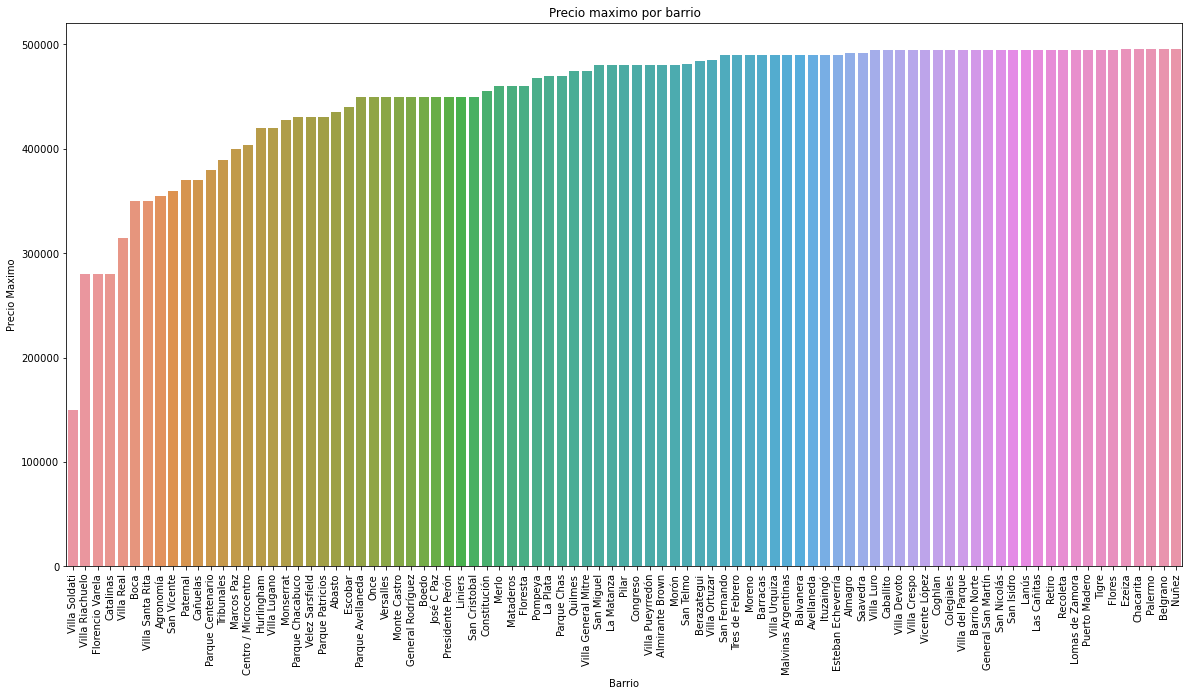

In [23]:
# Realizamos un grafico de barras de la distribucion del precio mayor.
plt.figure(figsize=(20, 10))
plt.title("Precio maximo por barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_max, x = "Barrio", y = 'Precio Maximo')

<AxesSubplot:title={'center':'Precio minimo por barrio'}, xlabel='Barrio', ylabel='Precio Minimo'>

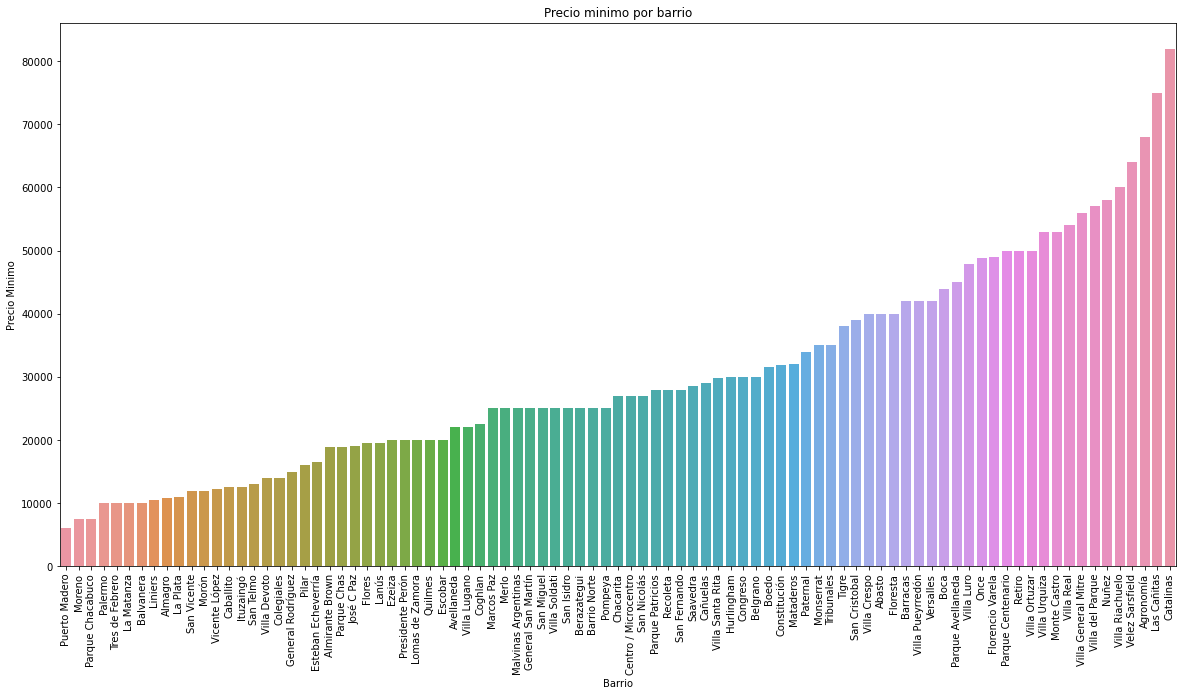

In [24]:
# Realizamos un grafico de barras de la distribucion del precio menor.
plt.figure(figsize=(20, 10))
plt.title("Precio minimo por barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_min, x = "Barrio", y = 'Precio Minimo')

Para continuar con el analisis del valor por barrio, se establecieron los precios maximos y minimos registrados. En los valores maximos, debe tenerse en consideracion que no se estan trabajando valores atipicos, por lo cual presentan logica los valores observados que se corresponden con la cota maxima aplicada.

Del analisis de precios se observa:
* Villa Soldati presenta el valor mas bajo dentro de los precios maximos observados, cercano a 150.000,00, que se corresponde con el promedio para todos los barrios segun lo observado en "barrio_precio", situacion que nos permite tomar mejor entendimiento respecto a su ubicacion como el segundo barrio mas barato de Buenos Aires.
* Los 5 barrios mas caros (barrio_precio), presentan sus valores mas altos entre los primeros 15 registros de las propiedades mas caras (barrio_max).
* La variacion proporcional entre las propiedades de menor precio es mayor que las de mayor precio, siendo aproximadamente una diferencia de 13 veces entre la de mayor y menor registro. Mientras que para el caso de las propiedad de mayor precio, la diferencia es menor, siendo de un valor aproximado de 3 veces. En este ultimo caso, no se tiene en cuenta que la propiedad con el mayor precio se corresponde a un registro de 32 millones, valor que fue filtrado por el metodo de IQR al trabajar los Outliers.
* Llama particularmente la atencion los dos registros correspondientes a Puerto Madero, si consideramos que presenta el menor precio del registro pero igualmente se ubica en la primera posicion de los barrios con la media mas alta

Para complementar el analisis, es importante tomar en consideracion la cantidad de observaciones por barrio, a los fines de estimar la influencia que podria tener un valor atipico (ej/ 6.000 en puerto madero) al momento de influir en la media de dicho barrio.

In [25]:
# Se establece la cantidad de registros por barrio
barrio_obs = properati.groupby(['l3'])['price'].count()
barrio_obs = pd.DataFrame(barrio_obs.items(), columns = ['Barrio', 'Q Registros'])
barrio_obs = barrio_obs.sort_values(['Q Registros']).reset_index(drop=True)

<AxesSubplot:title={'center':'Distribucion de observaciones por Barrio'}, xlabel='Barrio', ylabel='Q Registros'>

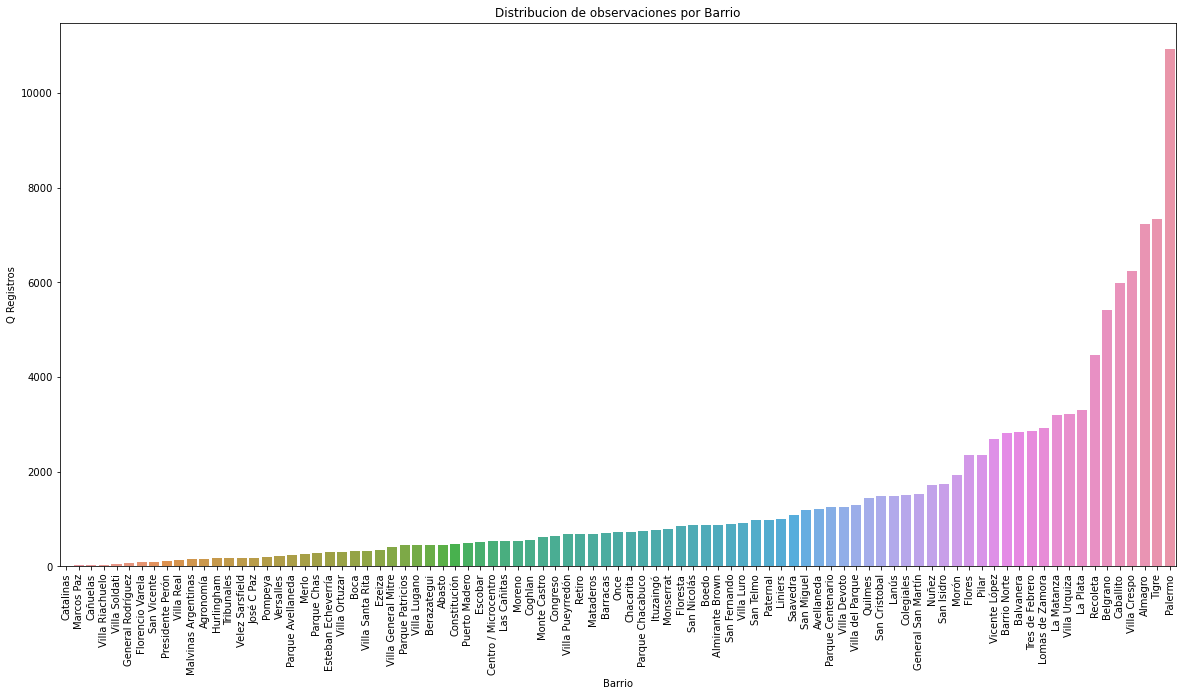

In [26]:
# Se grafica la distribucion anterior
plt.figure(figsize=(20, 10))
plt.title("Distribucion de observaciones por Barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_obs, x = "Barrio", y = 'Q Registros')

In [27]:
# Imprimimos la funcion describe() de la cantidad de registros por barrio.
barrio_obs.describe()

,Q Registros
count,89.000000
mean,1376.348315
std,1877.125765
min,5.000000
25%,309.000000
50%,729.000000
75%,1491.000000
max,10936.000000


Atento a lo observado en el grafico anterior, si mantenemos el analisis en los barrios que figuraban con un promedio mas alto de precios (Puerto Madero, Las Cañitas, Recoleta, Belgrano, San Isidro), podemos afirmar que tanto Puerto Madero como Las Cañitas presentan una cantidad baja de registros lo que puede significar que ante la presencia de publicaciones con valores altos, su valor promedio se veria incrementado en una proporcion mayor que en barrios como Recoleta, Belgrano o San Isidro.

Buscando completar este analisis, se procedera a determinar los valores por metro cuadrado de superficie total por tipo de propiedad y para cada barrio.

In [28]:
# Establecemos la media de la superficie por tipo de propiedad
superficie_propiedad = properati.groupby(['property_type'])['surface_total'].mean()
superficie_propiedad = pd.DataFrame(superficie_propiedad.items(), columns = ['Tipo Propiedad', 'Superficie Media'])

In [29]:
# Concatenamos el precio medio y la superficie correspondientes
properati_resume = pd.merge(precio_propiedad, superficie_propiedad, on = "Tipo Propiedad")
properati_resume.head()

,Tipo Propiedad,Precio Medio,Superficie Media
0,Oficina,157225.803252,73.609203
1,PH,170246.178912,106.511192
2,Departamento,174902.910161,72.359588
3,Lote,175815.672945,101.861008
4,Local comercial,177041.629032,81.005703


In [30]:
# Establecemos el precio por metro de cada tipo de propiedad
properati_resume['Precio por metro'] = properati_resume['Precio Medio']/properati_resume['Superficie Media']

In [31]:
# Imprimimos en pantalla los 5 primeros registros.
properati_resume.head()

,Tipo Propiedad,Precio Medio,Superficie Media,Precio por metro
0,Oficina,157225.803252,73.609203,2135.953067
1,PH,170246.178912,106.511192,1598.387704
2,Departamento,174902.910161,72.359588,2417.135243
3,Lote,175815.672945,101.861008,1726.035076
4,Local comercial,177041.629032,81.005703,2185.545241


<AxesSubplot:title={'center':'Precio por metro cuadrado por tipo de propiedad'}, xlabel='Tipo Propiedad', ylabel='Precio por metro'>

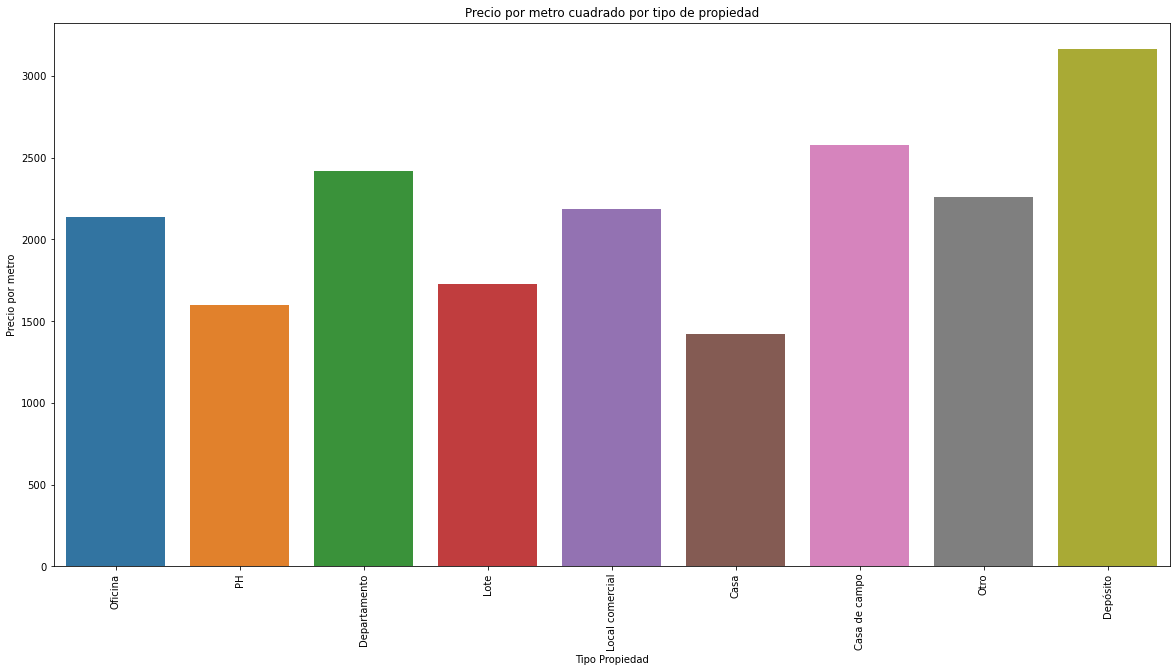

In [32]:
# Generamos un grafico para observar con claridad la distribucion anterior.
plt.figure(figsize=(20, 10))
plt.title("Precio por metro cuadrado por tipo de propiedad")
plt.xticks(rotation=90)
sns.barplot(data = properati_resume, x = "Tipo Propiedad", y = 'Precio por metro')

Del grafico anterior, se observa que los depositos son los mas caros en el precio por metro total. Adicionalmente, si nos enfocamos en los inmuebles para vivienda, las casas de campo presentan el mayor costo, seguidos por los departamentos, los PH y finalmente las Casas.

In [33]:
# Establecemos la media de la superficie por tipo de propiedad
sup_barrio = properati.groupby(['l3'])['surface_total'].mean()
sup_barrio = pd.DataFrame(sup_barrio.items(), columns = ['Barrio', 'Superficie Media'])
sup_barrio.head()

,Barrio,Superficie Media
0,Abasto,73.699348
1,Agronomía,80.011314
2,Almagro,74.508026
3,Almirante Brown,93.459527
4,Avellaneda,86.968684


In [34]:
# Concatenamos el precio medio y la superficie correspondientes
prop_precio = pd.merge(barrio_precio, sup_barrio, on = "Barrio")
prop_precio.head()

,Barrio,Precio Medio,Superficie Media
0,José C Paz,71583.989189,104.302638
1,Villa Soldati,78093.877551,105.825158
2,Constitución,96069.741866,66.728000
3,Villa Lugano,104533.401345,88.454619
4,Tres de Febrero,105337.613095,82.046367


In [35]:
# Establecemos el precio por metro de cada tipo de propiedad
prop_precio['Precio por metro'] = prop_precio['Precio Medio']/prop_precio['Superficie Media']

In [36]:
prop_precio.head()

,Barrio,Precio Medio,Superficie Media,Precio por metro
0,José C Paz,71583.989189,104.302638,686.310441
1,Villa Soldati,78093.877551,105.825158,737.951911
2,Constitución,96069.741866,66.728000,1439.721590
3,Villa Lugano,104533.401345,88.454619,1181.774364
4,Tres de Febrero,105337.613095,82.046367,1283.879068


In [37]:
# Ordenamos los registros del Dataframe
prop_precio = prop_precio.sort_values(by=['Precio por metro'])

<AxesSubplot:title={'center':'Precio por metro cuadrado por barrio'}, xlabel='Barrio', ylabel='Precio por metro'>

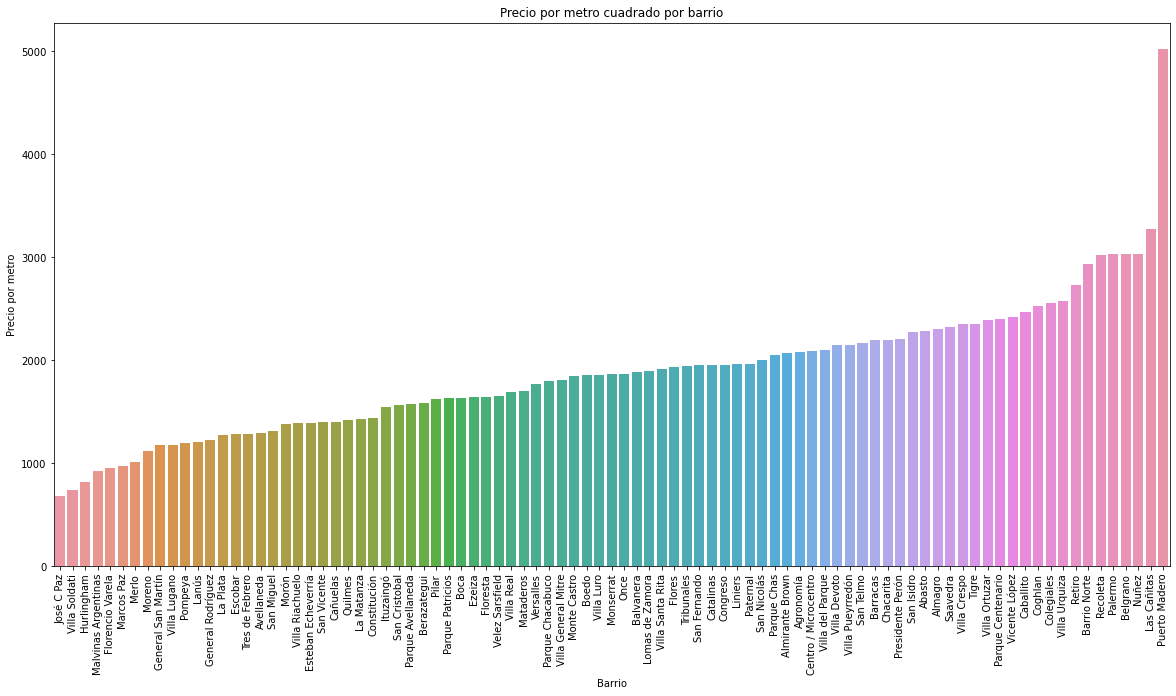

In [38]:
# Generamos un grafico para observar con claridad la distribucion anterior.
plt.figure(figsize=(20, 10))
plt.title("Precio por metro cuadrado por barrio")
plt.xticks(rotation=90)
sns.barplot(data = prop_precio, x = "Barrio", y = 'Precio por metro')

In [39]:
# Imprimimos el registro de los 10 barrios mas caros por metro cuadrado
prop_precio.tail(10)

,Barrio,Precio Medio,Superficie Media,Precio por metro
75,Colegiales,193397.112075,75.733038,2553.669016
71,Villa Urquiza,191144.930218,74.061900,2580.880709
79,Retiro,218620.878698,79.905533,2735.991749
83,Barrio Norte,229705.751507,78.298067,2933.734632
86,Recoleta,249145.123321,82.532639,3018.746613
81,Palermo,220622.055962,72.772547,3031.666004
85,Belgrano,237426.270390,78.225641,3035.146386
80,Nuñez,220133.949389,72.497328,3036.442263
87,Las Cañitas,268136.743925,81.940558,3272.332407
88,Puerto Madero,352646.204082,70.150030,5027.028572


In [40]:
# Ordenamos por precio el dataframe del precio por metro de las propiedades
properati_resume = properati_resume.sort_values(['Precio por metro']).reset_index(drop=True)
properati_resume

,Tipo Propiedad,Precio Medio,Superficie Media,Precio por metro
0,Casa,190559.275583,134.030366,1421.761960
1,PH,170246.178912,106.511192,1598.387704
2,Lote,175815.672945,101.861008,1726.035076
3,Oficina,157225.803252,73.609203,2135.953067
4,Local comercial,177041.629032,81.005703,2185.545241
5,Otro,225484.060606,99.760125,2260.262400
6,Departamento,174902.910161,72.359588,2417.135243
7,Casa de campo,210915.254237,81.873720,2576.104436
8,Depósito,258289.655172,81.544421,3167.471823


Del analisis realizado hasta el momento, si consideramos como criterio de alquiler el precio por metro cuadrado de los distintos tipos de propiedad y el costo en misma medida de los 10 barrios mas caros, es logico asumir que si lo que buscamos es optimizar el uso de nuestros recursos, no alquilariamos un inmueble (indistintamente del tipo que se trate) en un barrio cuyo costo por metro es mayor a la media de todas las observaciones.

Atento a lo anterior, podriamos afirmar que de los 10 barrios mostrados anteriormente, en la mayoria de convinaciones (tipo de propiedad con barrio, ambos segun costo) la "rentabilidad" seria negativa, es decir, estariamos pagando un sobreprecio para vivir en dicha ubicacion. Esta situacion nos permite establecer que la diferencia que se pagaria por instalarse en uno de los barrios mas caros, esta justificada en distintos aspectos, por ejemplo:
* Calidad de vida
* Seguridad
* Disponibilidad de espacios verdes
* Cercania a Hospitales y Escuelas
* Prestigio por el lugar de vivienda

Para poseer un mejor criterio, se procedera a filtrar el Dataframe con el procesamiento de datos, para trabajar unicamente con departamentos, dado que si recordamos, los mismos son los que presentaban mayor cantidad de registros en las publicaciones.

In [41]:
# Filtramos el Dataframe para trabajar unicamente con los Departamentos
properati_dpt = properati.loc[(properati['property_type'] == 'Departamento')]

In [42]:
# Establecemos la media de la superficie de los departamentos por barrio.
properati_dpt_sup = properati_dpt.groupby(['l3'])['surface_total'].mean()
properati_dpt_sup = pd.DataFrame(properati_dpt_sup.items(), columns = ['Barrio', 'Superficie Media'])

In [43]:
# Establecemos la media del precio de los departamentos por barrio.
properati_dpt_pri = properati_dpt.groupby(['l3'])['price'].mean()
properati_dpt_pri = pd.DataFrame(properati_dpt_pri.items(), columns = ['Barrio', 'Precio Medio'])

In [44]:
# Unimos ambos valores en un unico dataframe
depto_resume = pd.merge(properati_dpt_sup, properati_dpt_pri, on = 'Barrio')

In [45]:
# Calculamos y agregamos una columna con el precio por metro
depto_resume['Precio por metro'] = depto_resume['Precio Medio']/depto_resume['Superficie Media']

In [46]:
# Ordenamos por precio el dataframe del precio por metro de las propiedades
depto_resume = depto_resume.sort_values(['Precio por metro']).reset_index(drop=True)
depto_resume.tail(10)

,Barrio,Superficie Media,Precio Medio,Precio por metro
79,Retiro,80.005338,219848.492355,2747.922796
80,San Isidro,86.488370,240654.084142,2782.502242
81,Barrio Norte,78.288728,230835.080204,2948.509762
82,Vicente López,74.590240,225957.568627,3029.318154
83,Recoleta,82.131214,249881.100441,3042.462016
84,Belgrano,76.812595,236144.429448,3074.293086
85,Palermo,70.205967,217321.993668,3095.491796
86,Nuñez,68.350207,216223.668153,3163.467663
87,Las Cañitas,81.668781,270311.842308,3309.855254
88,Puerto Madero,69.786033,353593.846154,5066.828292


In [47]:
# Del registro de precio medio por propiedad, tomamos el correspondiente a Departamento al ser el relevante para continuar el analisis.
properati_resume.loc[(properati_resume['Tipo Propiedad'] == 'Departamento')]

,Tipo Propiedad,Precio Medio,Superficie Media,Precio por metro
6,Departamento,174902.910161,72.359588,2417.135243


In [48]:
# Establecemos un Dataframe con los barrios donde el precio por metro se encuentra por encima de la media.
barrio_caro = depto_resume.loc[(depto_resume['Precio por metro'] >= 2417.13)]
barrio_caro.tail()

,Barrio,Superficie Media,Precio Medio,Precio por metro
84,Belgrano,76.812595,236144.429448,3074.293086
85,Palermo,70.205967,217321.993668,3095.491796
86,Nuñez,68.350207,216223.668153,3163.467663
87,Las Cañitas,81.668781,270311.842308,3309.855254
88,Puerto Madero,69.786033,353593.846154,5066.828292


In [49]:
# Generamos un Dataframe con los barrios donde el precio por metro se encuentra por debajo de la media.
barrio_barato = depto_resume.loc[(depto_resume['Precio por metro'] < 2417.13)]
barrio_barato.tail()

,Barrio,Superficie Media,Precio Medio,Precio por metro
65,Almagro,72.055020,168303.268022,2335.760492
66,Chacarita,62.955975,148325.081670,2356.012768
67,Villa Crespo,64.194845,153058.455685,2384.279538
68,Parque Centenario,79.328860,190268.630078,2398.479316
69,Tigre,87.877574,211799.234404,2410.162522


<AxesSubplot:title={'center':'Precio por metro cuadrado por barrio'}, xlabel='Barrio', ylabel='Precio por metro'>

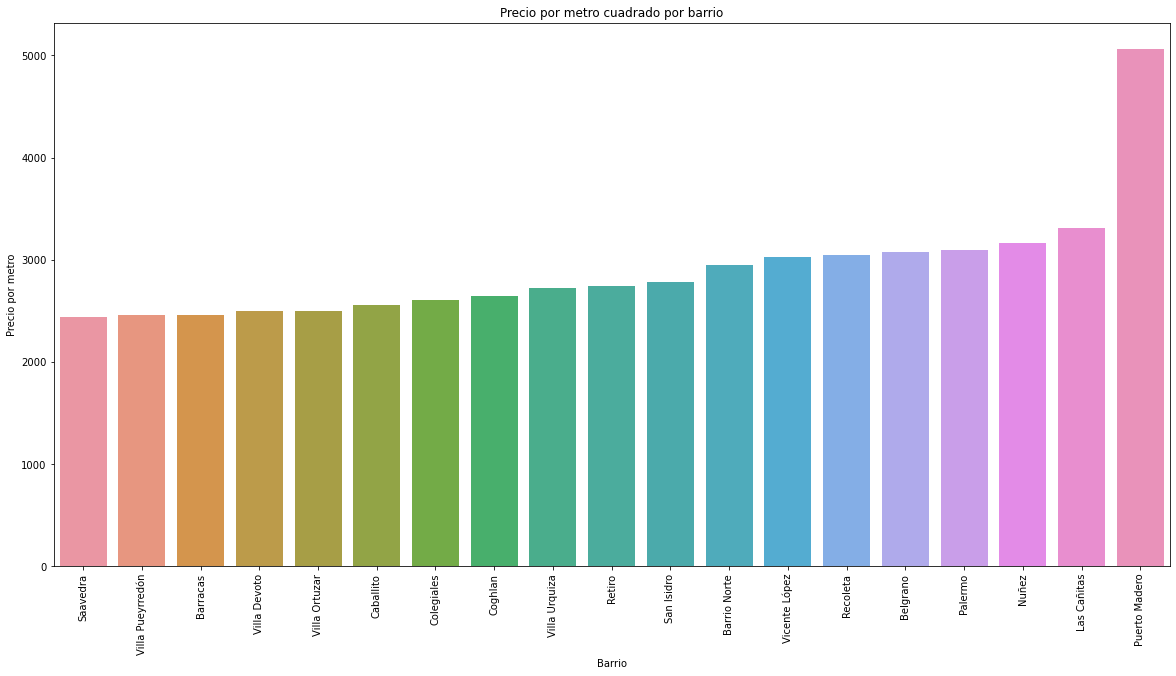

In [50]:
# Generamos un grafico para observar con claridad la distribucion anterior.
plt.figure(figsize=(20, 10))
plt.title("Precio por metro cuadrado por barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_caro, x = "Barrio", y = 'Precio por metro')

<AxesSubplot:title={'center':'Precio por metro cuadrado por barrio'}, xlabel='Barrio', ylabel='Precio por metro'>

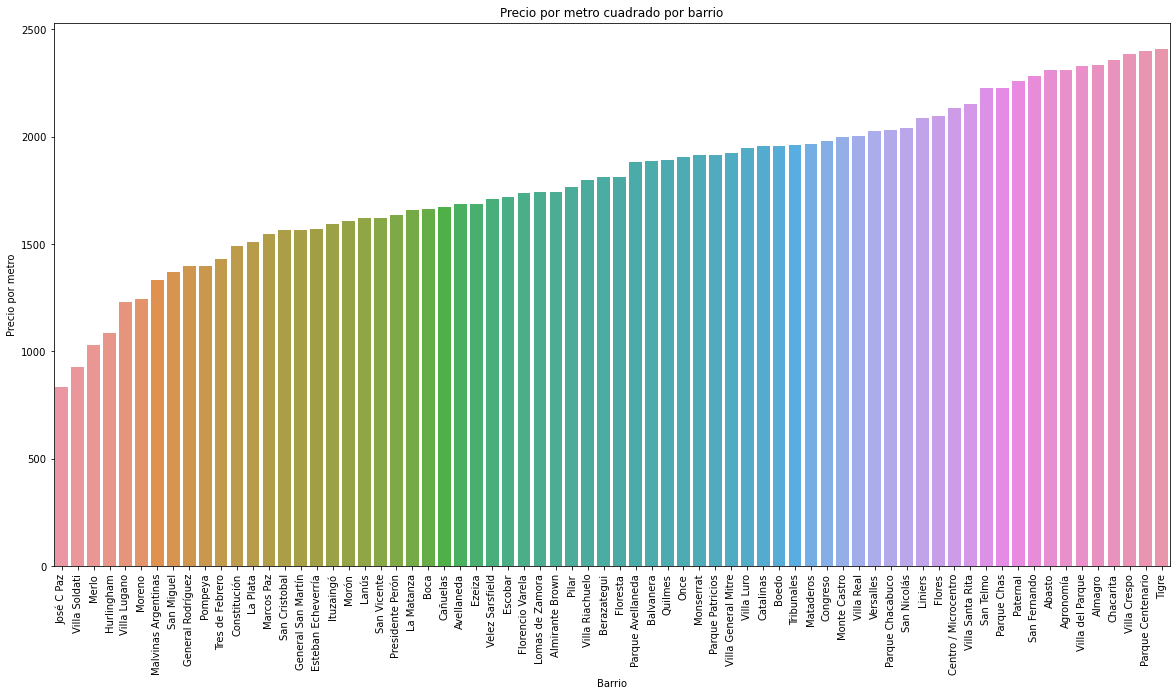

In [51]:
# Generamos un grafico para observar con claridad la distribucion anterior.
plt.figure(figsize=(20, 10))
plt.title("Precio por metro cuadrado por barrio")
plt.xticks(rotation=90)
sns.barplot(data = barrio_barato, x = "Barrio", y = 'Precio por metro')

De los analisis realizados, al enfocarnos unicamente en Departamentos, se observa:
* De los 89 Barrios que conforman el Dataframe, hay 19 que se encuentran con un precio por encima de la media.
* La aplicacion del filtro en el tipo de propiedad, si bien genero algunas modificaciones respecto al DF completo si tomamos en consideracion el precio medio por barrio, los 5 mas caros siguen figurando entre los primeros 10. Situacion que es coincidente con el hecho de que, como se menciono anteriormente, el Dataframe original presenta mayor participacion de registros de Departamentos que otro tipo de inmueble.
* Puerto Madero sigue posicionandose en el primer lugar y con marcada diferencia en su valor medio respecto al siguiente.

In [52]:
# Se establece la cantidad de registros por barrio
barrio_obs_dpto = properati_dpt.groupby(['l3'])['price'].count()
barrio_obs_dpto = pd.DataFrame(barrio_obs_dpto.items(), columns = ['Barrio', 'Q Registros'])
barrio_obs_dpto = barrio_obs_dpto.sort_values(['Q Registros']).reset_index(drop=True)

In [53]:
# Se completa el Dataframe con la cantidad de registros que posee
depto_resume = pd.merge(depto_resume, barrio_obs_dpto, on = 'Barrio')
depto_resume = depto_resume.sort_values(['Q Registros']).reset_index(drop=True)

<AxesSubplot:title={'center':'Precio por metro cuadrado por barrio'}, xlabel='Barrio', ylabel='Q Registros'>

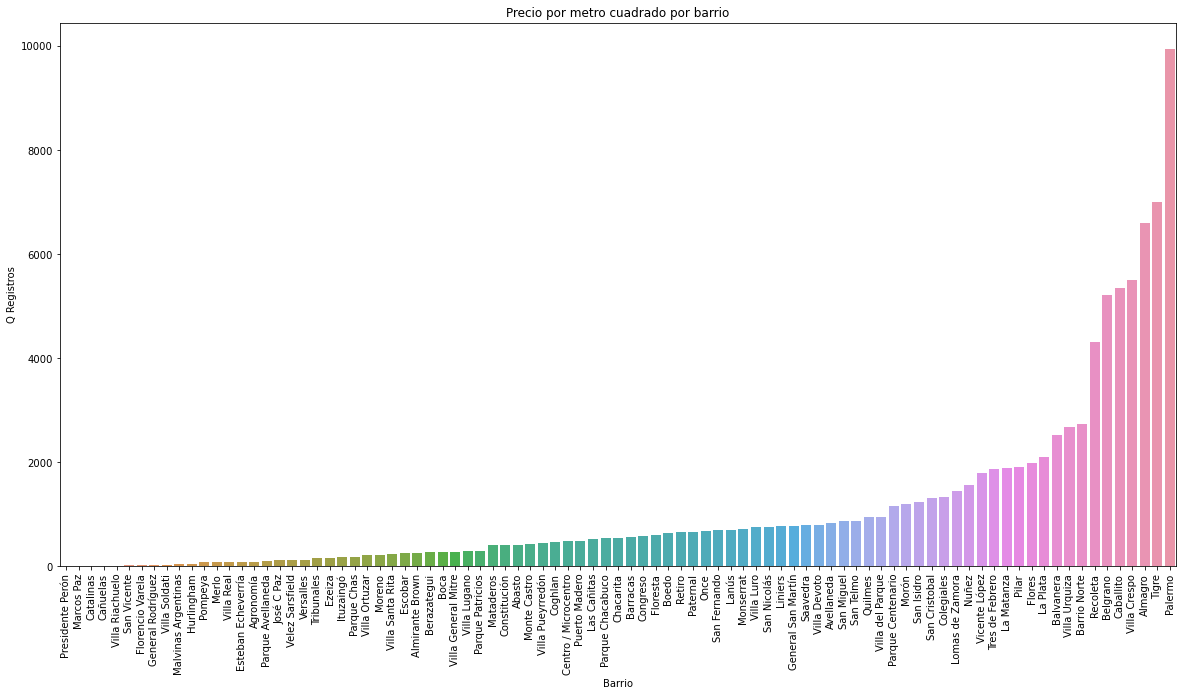

In [54]:
# Generamos un grafico para observar con claridad la distribucion anterior.
plt.figure(figsize=(20, 10))
plt.title("Precio por metro cuadrado por barrio")
plt.xticks(rotation=90)
sns.barplot(data = depto_resume, x = "Barrio", y = 'Q Registros')

In [55]:
# Establecemos un filtro para aquellos barrios que presentan mas de 1000 registros
registros_mas = depto_resume.loc[(depto_resume['Q Registros'] > 1000)]
registros_mas.count()

Barrio              23
Superficie Media    23
Precio Medio        23
Precio por metro    23
Q Registros         23
dtype: int64

### Conclusiones
A lo largo del analisis exploratorio y como se planteo al principio, lo que se busco fue brindar con informacion completa y de manera clara, un criterio objetivo para tomar una decision referida a alquilar un inmueble. En un primer momento se trabajo con todos los tipos de propiedad disponible y se pudo observar con claridad que la mayoria de los barrios presentan precios acordes a los valores generales de la Ciudad, tomando como criterio el precio medio por metro cuadrado del tipo de propiedad correspondiente.

En segundo lugar se realizo el mismo analisis pero trabajando unicamente con los registros que se correspondan a Departamentos, en este aspecto, si bien las observaciones variaron, se pudo determinar y establecer, bajo el mismo criterio aplicado anteriormente, que existen 19 Barrios que presentan un sobreprecio que puede corresponderse a diversos factores que podriamos denominarlos "sentimentales", pero solo Puerto Madero, presenta una diferencia significativa en relacion al resto.

Finalmente, se establecio como criterio trabajar sobre aquellos barrios que presentan mas de 1000 registros como recomendacion, dado que serian en aquellos lugares donde al encontrarse mayor variedad, podria conseguirse mayor variacion en los precios y no limitarse en ultima instancia a filtrar unicamente por una unica medida de decision.

#### Pendiente
El analisis se realizo tomando en cuenta como criterio el alquiler. Es interesante pensar en realizar un analisis similar, trabajando sobre todo el Dataframe disponible en la pagina de Properati para toda la Argentina (https://www.properati.com.ar/data, https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz) para realizar un analisis de inversion partiendo de comparaciones entre los precios de compra en las distintas provincias y barrios y compararlos con los precios de alquiler, pensando en la inversion como el proceso de adquirir un inmueble para destinarlo a un alquiler mensual.


In [56]:
# Liberamos espacio para preparar el DF para la aplicacion de modelos.
del properati
del precio_propiedad
del barrio_precio
del barrio_max
del barrio_min
del barrio_obs
del superficie_propiedad
del properati_resume
del sup_barrio
del prop_precio
del properati_dpt
del properati_dpt_sup
del properati_dpt_pri
del depto_resume
del barrio_caro
del barrio_barato
del barrio_obs_dpto
del registros_mas
gc.collect()

44

### Modelos

#### Procedemos a realizar los mismos pasos aplicados para el proyecto 02 - Escalado de valores, Outliers y valores nulos

In [57]:
#Cargamos el DataSet correspondiente para trabajar
properti = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

In [58]:
#Se filtra el dataframe a los fines de tomar solo aquellas variables que son importantes. Se dejan de lado las fechas de creacion y cierre, 
#la moneda a la cual se esta valuando, la descripcion de la propiedad y el tipo de operacion
properti_1 = properti[['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]

In [59]:
# Se procedera a realizar un escalado de datos usando Robust Scaler de sklearn, atento a que funciona mejor cuando se observan muchos Outliers, situacion observada en el proyecto 01
properti_scaler = properti_1[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].copy() # Se crea una copia del DF para aplicar el escalado correspondiente
col_names = list(properti_scaler.columns) # Se crea una variable que contenga una lista con los nombres de las columnas a los fines de utilizarla posteriormente

#### Escalado de valores con Robust Scaler

In [60]:
from sklearn.preprocessing import RobustScaler # Se importa el modelo a utilizar
r_scaler = RobustScaler() # Se crea el objeto correspondiente
properti_r = r_scaler.fit_transform(properti_scaler) # Se crea la variable con los valores ajustado
properti_r = pd.DataFrame(properti_r, columns=col_names) # Se crea el DataFrame con los valores obtenidos en el paso anterior

In [61]:
# Se agregan las variables property_type y barrio al DF, y se deja listo para realizar tratamiento de Outliers.
properti_r['property_type'] = properti_1['property_type']
properti_r['barrio'] = properti_1['l3']
properti_r['price'] = properti_1['price']
properti_r

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,barrio,price
0,2.0,2.5,1.0,0.704545,1.180328,Departamento,San Cristobal,153000.0
1,-0.5,-0.5,1.0,-0.090909,-0.163934,PH,Boedo,159000.0
2,-0.5,-0.5,0.0,-0.375000,-0.377049,PH,Palermo,125000.0
3,-0.5,-0.5,0.0,0.079545,-0.295082,PH,Palermo,295000.0
4,-0.5,-0.5,0.0,-0.318182,-0.540984,PH,La Plata,40000.0
...,...,...,...,...,...,...,...,...
146655,-0.5,-0.5,0.0,-0.272727,-0.327869,Departamento,Berazategui,165000.0
146656,0.5,0.5,1.0,0.977273,0.360656,Departamento,Pilar,130000.0
146657,-1.0,-0.5,0.0,-0.318182,-0.540984,Departamento,Pilar,73000.0
146658,-0.5,-0.5,0.0,-0.454545,-0.491803,Departamento,Pilar,68000.0


#### Tratamiento de Outliers por IQR

In [62]:
#Procedemos a determinar minimo, maximo e IQR para las variables observadas e imprimimos los valores correspondientes
Q1 = properti_r.quantile(0.25)
Q3 = properti_r.quantile(0.75)
iqr = Q3 - Q1
minimo = Q1 - 1.5*iqr
maximo = Q3 + 1.5*iqr
print("Valor minimo: ", minimo)
print("Valor maximo: ", maximo)
print("IQR: ", iqr)

Valor minimo:  rooms                  -2.000000
bedrooms               -2.000000
bathrooms              -1.500000
surface_total          -1.795455
surface_covered        -1.844262
price             -120000.000000
dtype: float64
Valor maximo:  rooms                   2.000000
bedrooms                2.000000
bathrooms               2.500000
surface_total           2.204545
surface_covered         2.155738
price              496000.000000
dtype: float64
IQR:  rooms                   1.0
bedrooms                1.0
bathrooms               1.0
surface_total           1.0
surface_covered         1.0
price              154000.0
dtype: float64


In [63]:
# Realizamos el filtrado correspondiente de acuerdo a los valores obtenidos en el punto anterior.
properti_r_out = properti_r[~((properti_r < minimo) |(properti_r > maximo)).any(axis=1)] # Se establece un DF para continuar trabajando, el cual ya presenta escalado de datos y tratamiento de Outliers.
properti_r_out.shape

(122754, 8)

#### Tratamiento de valores nulos

In [64]:
# Se determina la presencia de valores faltantes.
properti_r_out.isna().sum()

rooms                  0
bedrooms               0
bathrooms           4896
surface_total      18678
surface_covered    19072
property_type          0
barrio                 0
price                  0
dtype: int64

In [65]:
# Se observan valores faltantes en 3 variables. A los fines de completarlas y, 
# atento a que se esta trabajando con un DF "sin" outliers, se procedera a completar con la media de las observaciones,
# situacion que es factible atento a que solo faltan valores "numericos"
properti_r_clean = properti_r_out.fillna(properti_r_out.mean())

In [66]:
# Establecemos el DF definitivo para continuar con el analisis. Trabajando tambien con aquellas propiedad de tipo "Departamento", "PH" y "Casa".
properti_final = properti_r_clean.loc[((properti_r_clean['property_type'] == 'Departamento') | (properti['property_type'] == 'PH') | (properti['property_type'] == 'Casa'))].copy()

In [67]:
properti_final.isna().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_type      0
barrio             0
price              0
dtype: int64

In [68]:
properti_final.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,120679.000000,120679.000000,120679.000000,120679.000000,120679.000000,120679.000000
mean,-0.110425,-0.118513,0.383169,0.035576,0.000472,175706.282004
std,0.528136,0.462520,0.582089,0.478301,0.490570,92708.003663
min,-1.000000,-1.000000,0.000000,-0.772727,-1.098361,6000.000000
25%,-0.500000,-0.500000,0.000000,-0.306818,-0.360656,106000.000000
50%,0.000000,0.000000,0.000000,-0.022727,-0.032787,151500.000000
75%,0.000000,0.000000,1.000000,0.159091,0.163934,225000.000000
max,2.000000,2.000000,2.000000,2.204545,2.147541,496000.000000


Habiendose realizado el preprocesamiento correspondiente, se procedera a realizar distintos modelos, partiendo de la base del proyecto 02 en el cual se habia encontrado:
* Las variables con mayor importancia relativa eran: bathrooms, surface covered y surface total, motivo por el cual estas seran utilizadas para entrenar los modelos.
* Al considerarse todas las variables, el mejor resultado obtenido para el modelo SVR era con un kernel linear.
* De los 3 modelos entrenados, el que mejor resultado habia presentado era el Random Forest con optimizacion de hiperparametros por GridSearchCV

### Arbol de Decision - Modelo Benchmark

In [69]:
# Se establece una variable que incorpore las columnas que decidan utilizarse para los valores de X o variables predictoras.
# En este momento, se trabaja sobre el DF con el preprocesamiento realizado en los puntos anterior.
values = ['surface_total', 'bathrooms', 'surface_covered']
X = properti_final[values]
y = properti_final['price']

In [70]:
#Se importan las librerias y funcionalidades correspondientes y se crean las variables de entrenamiento y prueba para los modelos
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [71]:
# Se establece y entrena el modelo de arboles de decisiones, iniciando el modelo con un max_depth de 3. Se establece tambien el valor del
# error cuadratico para dichos hiperparametros
reg_tree = DecisionTreeRegressor (max_depth = 3, random_state = 42)
reg_tree.fit(X_test, y_test)
y_pred = reg_tree.predict(X_test)
error_reg_tree = sqrt(mean_squared_error(y_test, y_pred))
print(error_reg_tree)

67423.37214285131


##### Se establecen las variables X e Y y se realiza el split correspondiente para el modelo SVR y Random Forest

In [72]:
# Se procede a crear las variables X e Y para los modelos a implementar, y posteriormente se realiza el split en variables de prueba y entrenamiento.
X_mod_a = properti_final[values]
y_mod_a = properti_final['price']
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_mod_a, y_mod_a, test_size = 0.3, random_state = 0)

In [73]:
del reg_tree
gc.collect()

66

#### Modelo SVR

Se procede a crear y entrenar modelos de SVR variando el hiperparametro "Kernel". 

In [74]:
# Se importa el modelo a utilizar y se crea, entrena y calcula el error cuadratico para un kernel linear.
from sklearn.svm import SVR
mod_svr = SVR(kernel='linear')
mod_svr.fit(X_train_a, y_train_a)
y_pred = mod_svr.predict(X_test_a)
error_mod_svr = sqrt(mean_squared_error(y_test_a, y_pred))

In [75]:
# Se crea, entrena y calcula el error cuadratico para un kernel poly
mod_svr_p = SVR(kernel= 'poly')
mod_svr_p.fit(X_train_a, y_train_a)
y_pred_p = mod_svr_p.predict(X_test_a)
error_mod_svr_p = sqrt(mean_squared_error(y_test_a, y_pred_p))

In [76]:
# Se crea, entrena y calcula el error cuadratico para un kernel rbf
mod_svr_r = SVR(kernel = 'rbf')
mod_svr_r.fit(X_train_a, y_train_a)
y_pred_r = mod_svr_r.predict(X_test_a)
error_mod_svr_r = sqrt(mean_squared_error(y_test_a, y_pred_r))

In [77]:
# Se crea, entrena y calcula el error cuadratico para un kernel sigmoid
mod_svr_s = SVR(kernel = 'sigmoid')
mod_svr_s.fit(X_train_a, y_train_a)
y_pred_s = mod_svr_s.predict(X_test_a)
error_mod_svr_s = sqrt(mean_squared_error(y_test_a, y_pred_s))

In [78]:
# Definimos una funcion para definir cual es el modelo SVR con menor SQRT, la funcion trabaja indistintamente cuales sean los valores y variables utilizadas en X.
# El objetivo es utilizar como punto de comparacion aquella "version" que posea el mejor resultado a los fines de compararlo con el segundo modelo a implementar.
def mejor_resultado (error_mod_svr, error_mod_svr_p, error_mod_svr_r, error_mod_svr_s):
    mejor = 0
    kernel = ""
    if error_mod_svr < error_mod_svr_p and error_mod_svr < error_mod_svr_r and error_mod_svr < error_mod_svr_s:
        mejor = error_mod_svr
        kernel = "linear"
    elif error_mod_svr_p < error_mod_svr_r and error_mod_svr_p < error_mod_svr_s:
        mejor = error_mod_svr_p
        kernel = "poly"
    elif error_mod_svr_r < error_mod_svr_s:
        kernel = "rbf"
        mejor = error_mod_svr_r
    else:
        kernel = "sigmoid"
        mejor = error_mod_svr_s
    print("El mejor resultado se obtuvo para un kernel:", kernel, " con un valor de:", mejor)

In [79]:
# Se aplica la formula anterior para determinar el kernel que obtuvo mejor resultado.
mejor_resultado(error_mod_svr, error_mod_svr_p, error_mod_svr_r, error_mod_svr_s)

El mejor resultado se obtuvo para un kernel: poly  con un valor de: 81069.31016048453


In [80]:
del mod_svr
del mod_svr_p
del mod_svr_r
del mod_svr_s
gc.collect()

44

Al modificar la cantidad de variables utilizadas para realizar la prediccion, se observa una diferencia en los resultados obtenidos, siendo para este caso el mejor modelo un kernel 'poly' y obteniendo un resultado de sqrt mayor al obtenido con todas las variables.

#### Modelo Random Forest con GridSearch

In [81]:
# Importamos la libreria a utilizar y generamos el modelo correspondiente
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor()

In [82]:
# Importamos la libreria de GridSearchCV para utilizarla con el fin de optimizar los hiperparametros.
from sklearn.model_selection import GridSearchCV

In [83]:
# Definimos el param_grid para utilizar en el Grid Search - Se trabaja con los mismos valores que en el proyecto anterior.
param_grid = {'n_estimators': [100, 250, 500, 750, 1000],
              'random_state': [0, 35, 42, 49],
              'criterion': ['mse'],
              'max_depth':[10, 15, 20]}              

In [84]:
# Creamos el modelo del GridSearch y lo asignamos a la variable grid_model
grid_model = GridSearchCV(forest_model, param_grid=param_grid, cv=2, n_jobs = 2)

In [85]:
# Aplicamos la funcion fit al grid_model. DEMANDA TIEMPO DE EJECUCION
grid_model.fit(X_train_a, y_train_a)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'criterion': ['mse'], 'max_depth': [10, 15, 20],
                         'n_estimators': [100, 250, 500, 750, 1000],
                         'random_state': [0, 35, 42, 49]})

In [86]:
# Cargamos los valores predichos por el modelo tomando los mejores parametros obtenidos
y_predict = grid_model.predict(X_test_a)
# Determinamos el error cuadradito de dicho modelo
error_grid = sqrt(mean_squared_error(y_test_a, y_predict))
# Imprimimos el resultado de criterio obtenido
print(error_grid)

59969.38804247941


En este punto se obtienen resultados similares a los obtenidos anteriormente, el modelo con mejor resultado sigue siendo el Random Forest, pero igualmente se observa una desmejoria en los resultados, dado que al utilizar todas las variables el error cuadratico se ubicaba en 53.274, mientras que al utilizar las 3 variables mas relevantes, el valor del error cuadratico es de 59.969.

In [87]:
# A fines informativos, imprimimos los mejores parametros obtenidos por el modelo
print("Mejores parametros: "+str(grid_model.best_params_))

Mejores parametros: {'criterion': 'mse', 'max_depth': 15, 'n_estimators': 1000, 'random_state': 0}


In [88]:
del grid_model
gc.collect()

119

Respecto a los mejores parametros, se observa solo una variacion para el random_state, siendo de 0 para el modelo actual y de 42 al utilizar todas las variables.

C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


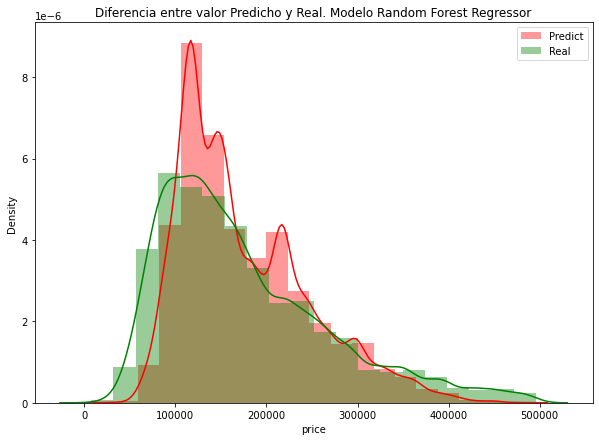

In [89]:
plt.figure(figsize = (10,7))
plt.title("Diferencia entre valor Predicho y Real. Modelo Random Forest Regressor")
sns.distplot(y_predict, bins = 20, color = 'r', label = 'Predict')
sns.distplot(y_test_a, bins = 20, color = 'g', label = 'Real')
plt.legend();

En terminos generales, se observa a simple vista, que el modelo predice bastante bien los precios de las propiedades, situacion que mejoro respecto al modelo de Arbol de Decision desarrollado en el proyecto 01. Adicionalmente, se observan dos diferencias importantes:

* 1- El modelo subestima los precios, cuando los mismos se encuentran en las colas de la distribucion, es decir, para aquellos valores bajos y altos.
* 2- En contraposicion a lo anterior, el modelo sobreestima los precios para aquellos valores que se encuentran mas centrados en la distribucion de valores reales.

Adicionalmente, se observa el mismo patron que el modelo entrenado para el proyecto 02.

In [90]:
# Se establece una variable que contenga la diferencia entre los valores reales y los predichos por el modelo con mejor resultado.
error_forest = y_test_a - y_predict

Text(0.5, 1.0, 'Distribucion de la diferencia de errores')

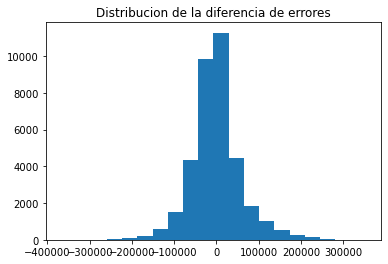

In [91]:
# Se establece un histograma con 20 agrupaciones en base a la variable definida anteriormente.
plt.hist(error_forest, bins = 20)
plt.title("Distribucion de la diferencia de errores")

El histograma realizado, nos sirve como un medio adicional para establecer que el modelo presenta un buen resultado para predecir los precios de las propiedades. En el grafico se observa una distribucion normal bien marcada, con una gran concentracion de valores en torno al 0 (la prediccion coincide con el valor real) y una disminucion bien brusca al alejarnos de dicho centro, indicando que son pocas las observaciones que presentan diferencias.

In [92]:
# Aplicamos la funcion describe para concluir el analisis del modelo
error_forest.describe()

count     36204.000000
mean       -616.545745
std       59967.046791
min     -367226.553144
25%      -32520.090073
50%       -3268.634166
75%       25891.223802
max      352954.243774
Name: price, dtype: float64

De los valores observados, se evidencia:
* La media se ubica cercana al 0, con un valor de -616
* La mediana se corresponde al valor -3.268, valor que si se toma en consideracion junto con el min y el max, podemos estimar (indistintamente que graficamente se haya confirmado) que la distribucion se corresponde con una normal.
* Merecen principal atencion los valores ubicados en los extremos, siendo de -367 mil y 352 mil, atento a que son valores altos dado que estamos considerando la diferencia entre lo predicho y lo real, y si tomamos en cuenta que el valor maximo del precio del dataframe es de 496.000, la relacion del error sobre dicho total es considerable.

#### AdaBoost Regressor

In [93]:
# Se cargan los valores para el modelo de AdaBoost y Gradient Boosting
values = ['surface_total', 'bathrooms', 'surface_covered']
X = properti_final[values]
y = properti_final['price']

In [94]:
# Se establece el split correspondiente.
X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [95]:
# Se genera el modelo de Ada Boost para usar como base_estimator
forest_model_ada = RandomForestRegressor()

In [96]:
# Se importa la libreria a utilizar, se genera el modelo, se entrena, se aplica la predicciones y se calcula el error cuadratico correspondiente.
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(base_estimator = forest_model_ada, n_estimators = 100, learning_rate = 0.1, random_state = 42)
ada.fit(X_train_ada, y_train_ada)
y_ada_predict = ada.predict(X_test_ada)
error_ada = sqrt(mean_squared_error(y_test_ada, y_ada_predict))
print(error_ada)

63659.84843104871


C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


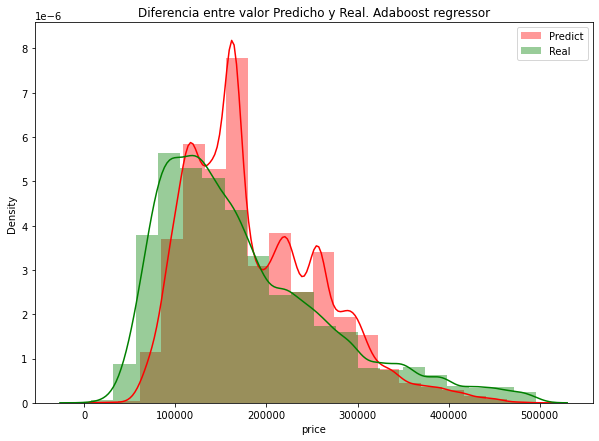

In [97]:
plt.figure(figsize = (10,7))
plt.title("Diferencia entre valor Predicho y Real. Adaboost regressor")
sns.distplot(y_ada_predict, bins = 20, color = 'r', label = 'Predict')
sns.distplot(y_test_ada, bins = 20, color = 'g', label = 'Real')
plt.legend();

De acuerdo al grafico, se observa que el modelo de Adaboost presenta las mismas "tendencias" que el Random Forest, sobreestimando los valores centrales y subestimando los valores en los extremos.

In [98]:
# Se cargan en una variable las diferencias observadas entre los valores reales y los predichos
error_ada = y_test_ada - y_ada_predict

Text(0.5, 1.0, 'Distribucion de la diferencia de errores')

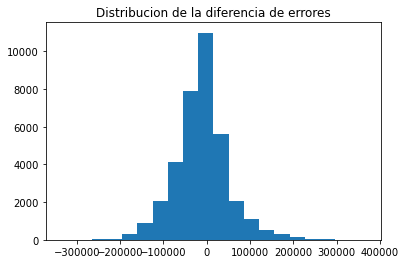

In [99]:
# Se establece un histograma con 20 agrupaciones en base a la variable definida anteriormente.
plt.hist(error_ada, bins = 20)
plt.title("Distribucion de la diferencia de errores")

Continuando con las mismas observaciones, la distribucion se corresponde a una Normal, a diferencia del modelo anterior en esta oportunidad se observa que la media no se ubica proxima a cero sino a un valor negativo.

In [100]:
# Aplicamos la funcion describe para concluir el analisis del modelo
error_ada.describe()

count     36204.000000
mean     -11613.926431
std       62592.341622
min     -336169.280952
25%      -45780.180619
50%      -10446.734560
75%       19166.164055
max      367136.583333
Name: price, dtype: float64

In [101]:
del ada
gc.collect()

12423

### Gradient Boosting Regressor

In [102]:
# Importamos la libreria correspondiente, cargamos el modelo, lo entrenamos, predecimos, calculamos el error cuadratico.
from sklearn.ensemble import GradientBoostingRegressor
gbreg = GradientBoostingRegressor(max_depth = 10, criterion = 'mse', random_state = 42)
gbreg.fit(X_train_ada, y_train_ada)
y_gbreg_pred = gbreg.predict(X_test_ada)
error_grad = sqrt(mean_squared_error(y_test_ada, y_gbreg_pred))
print(error_grad)

59992.29072296289


C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


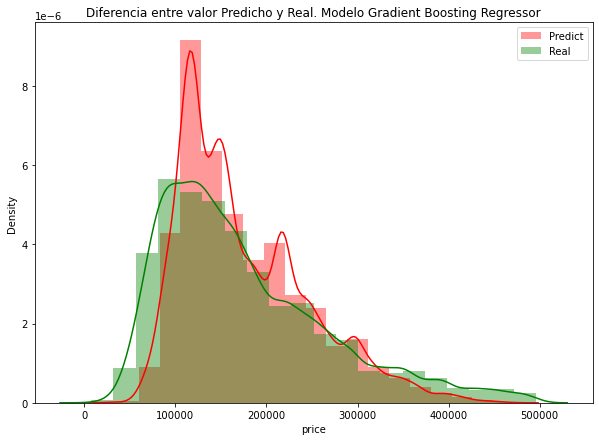

In [103]:
# Realizamos el grafico correspondiente para determinar las diferencias.
plt.figure(figsize = (10,7))
plt.title("Diferencia entre valor Predicho y Real. Modelo Gradient Boosting Regressor")
sns.distplot(y_gbreg_pred, bins = 20, color = 'r', label = 'Predict')
sns.distplot(y_test_ada, bins = 20, color = 'g', label = 'Real')
plt.legend();

In [104]:
# Guardamos en una variable la diferencia de los errores
error_grad = y_test_ada - y_gbreg_pred

Text(0.5, 1.0, 'Distribucion de la diferencia de errores')

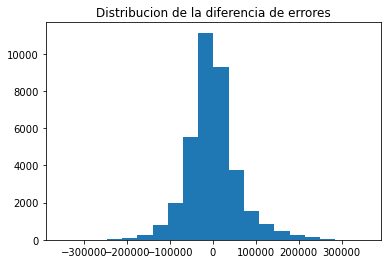

In [105]:
# Se establece un histograma con 20 agrupaciones en base a la variable definida anteriormente.
plt.hist(error_grad, bins = 20)
plt.title("Distribucion de la diferencia de errores")

In [106]:
# Aplicamos la funcion describe para concluir el analisis del modelo
error_grad.describe()

count     36204.000000
mean       -567.963404
std       59990.430642
min     -352773.717688
25%      -32860.775553
50%       -3615.694672
75%       25957.586635
max      355517.433012
Name: price, dtype: float64

Para la situacion de este modelo, se observan las mismas tendencias que en los casos anteriores. El modelo sobreestima precios centrales y subestima los valores en los extremos. Respecto a la distribucion de errores, se observa una Normal con centro en el 0(cero), acercandose mas al modelo de Random Forest que al de Adaboost.

In [107]:
del gbreg
gc.collect()

6029

In [108]:
# Generamos un dataframe con cada uno de los valores obtenidos de los modelos
error_grad_df = pd.DataFrame(error_grad.describe().items(), columns = ['Indicador', 'Valor GradBoost'])
error_ada_df = pd.DataFrame(error_ada.describe().items(), columns = ['Indicador', 'Valor AdaBoost'])
error_forest_df = pd.DataFrame(error_forest.describe().items(), columns = ['Indicador', 'Valor R Forest'])

In [109]:
# Unimos los DF del error de Adaboost y Gradient
error_total = pd.merge(error_grad_df, error_ada_df, on = 'Indicador')

In [110]:
# Agregamos al DF el error del forest
error_total = pd.merge(error_total, error_forest_df, on = 'Indicador')

In [111]:
# Generamos 3 variables para guardar el SQRT de cada modelo
ada_sqrt = sqrt(mean_squared_error(y_test_ada, y_ada_predict))
bos_sqrt = sqrt(mean_squared_error(y_test_ada, y_gbreg_pred))
for_sqrt = sqrt(mean_squared_error(y_test_a, y_predict))

In [112]:
# Agregamos la fila correspondiente al Dataframe
error_total = error_total.append({'Indicador' : 'SQRT' , 'Valor GradBoost' : bos_sqrt, 'Valor AdaBoost' : ada_sqrt, 'Valor R Forest' : for_sqrt} , ignore_index=True)

In [113]:
# Se generan 3 columnas adicionales con la diferencia entre los 3 modelos
error_total['Grad y Ada'] = error_total['Valor GradBoost'] - error_total['Valor AdaBoost']
error_total['Grad y Forest'] = error_total['Valor GradBoost'] - error_total['Valor R Forest']
error_total['Ada y Forest'] = error_total['Valor AdaBoost'] - error_total['Valor R Forest']

In [114]:
# Imprimimos en pantalla los valores obtenidos
error_total

,Indicador,Valor GradBoost,Valor AdaBoost,Valor R Forest,Grad y Ada,Grad y Forest,Ada y Forest
0,count,36204.000000,36204.000000,36204.000000,0.000000,0.000000,0.000000
1,mean,-567.963404,-11613.926431,-616.545745,11045.963028,48.582341,-10997.380686
2,std,59990.430642,62592.341622,59967.046791,-2601.910980,23.383850,2625.294831
3,min,-352773.717688,-336169.280952,-367226.553144,-16604.436735,14452.835456,31057.272192
4,25%,-32860.775553,-45780.180619,-32520.090073,12919.405067,-340.685480,-13260.090547
5,50%,-3615.694672,-10446.734560,-3268.634166,6831.039888,-347.060506,-7178.100394
6,75%,25957.586635,19166.164055,25891.223802,6791.422580,66.362833,-6725.059747
7,max,355517.433012,367136.583333,352954.243774,-11619.150322,2563.189238,14182.339560
8,SQRT,59992.290723,63659.848431,59969.388042,-3667.557708,22.902680,3690.460389


## Conclusion y pendiente

En primera medida, es importante tener en claro que al estar trabajando con la diferencia entre valores reales y predichos, el modelo que mas acerque a 0 (cero) los valores, sera el mejor para predecir los precios de una propiedad, atento a que un valor nulo indicaria que el modelo esta asignando el mismo precio que aquel al cual esta publicada dicha propiedad en el dataframe correspondiente.

De los modelos entrenados, podemos concluir:
* El modelo de Random Forest con GridSearch sigue presentando el mejor resultado si nos enfocamos en el criterio del SQRT, aunque sea por una diferencia de 22,91 puntos, lo que representa un aproximado del 0,03% respecto a los valores obtenidos.
* El modelo de SVR no se mantuvo en el analisis al presentar un valor de SQRT proximo a los 81 mil puntos, lo que implicaba una diferencia de 20 mil puntos aproximados.
* EL modelo del Arbol de Decision no se mantuvo en el analisis por presentar un valor de SQRT de 67 mil puntos, alcanzando una diferencia de 7 mil respecto a los modelos con mejores resultados.

A los fines de poder profundizar en el analisis, se procedio a determinar por medio de la funcion describe(), los valores aritmeticos pertinentes, y si nos enfocamos en los resultados obtenidos para la comparacion entre Grad y Forest (no se considera Adaboost al tener una diferencia negativa de 3 mil puntos sobre los otros dos modelos), obtenemos:
* Al tratarse el dataframe sobre la diferencia entre los valores reales y los predichos, ambos modelos estiman una media proxima entre si y cercana al 0. Siendo la del modelo de Gradient Boosting Regressor, mejor en 48 puntos, lo que representa un aproximado del 8% de mejora.
* Respecto a la desviacion estandar, el modelo del Random Forest presenta una leve mejoria respecto a su comparacion, pero dicho valor es casi nulo al ser proximo a 23 puntos, representando un 0,03% del total.
* Respecto al 1er y 3er cuartil y el valor de la mediana, no se observan diferencias significativas. Al incluir en el analisis los valores Minimos y Maximos observados, por la diferencia entre ambos podemos afirmar que el modelo de Gradient Boosting estaria acotando levemente los limites pero distribuye mas las observaciones (acorde a lo observado en la std).

De acuerdo a los analisis realizados, seria indistinto utilizar el modelo de Gradient Boosting Regressor o Random Forest, ambos presentan valores similares en las distintas metricas consideradas, en este aspecto se deberia profundizar en los analisis y en la determinacion de Hiperparametros para cada uno a los fines de analizar las distintas variaciones que puedan llegar a presentarse.

#### Explicacion del funcionamiento de Adaboost y Gradient Boosting

Ambos modelos parten del concepto de Boosting, que hace referencia a establecer modelos de prediccion precisos en base a modelos base o estimadores debiles.

Ambos modelos son modelos avanzados de machine learning, partiendo de un estimador incial, realizan sucesivas iteraciones trabajando en los resultados del modelo anterior para mejorar el desempeño. 

En el caso de Adaboost, se toma un algoritmo base (base_estimator) y busca mejorar el resultado por medio de sucesivas iteraciones, y a medida que avanza en el proceso se "enfoca" en los casos incorrectamente clasificados del conjunto de entrenamiento.

En el caso de Gradient Boosting, el proceso es similar pero se incluye una funcion de perdida que el modelo busca optimizar y un algoritmo de aprendizaje debil, que a diferencia de Adaboost, en este caso no se puede seleccionar si no que el propio modelo considera los arboles de decision. Otra diferencia con el modelo de Ada, es que en Gradient los arboles se van incoporando de uno a la vez en el modelo y los ya existentes no presentan modificaciones, y los nuevos arboles ven modificados sus parametros. El modelo realiza combinaciones de los distintos arboles para minimzar la funcion de perdida y mejorar de esa forma la prediccion.